## Build a model using Keras

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import requests


In [0]:
### Download data from google drive. You need not mess with this code.

import requests

def download_file_from_google_drive(id, destination):
    URL = "https://docs.google.com/uc?export=download"

    session = requests.Session()

    response = session.get(URL, params = { 'id' : id }, stream = True)
    token = get_confirm_token(response)

    if token:
        params = { 'id' : id, 'confirm' : token }
        response = session.get(URL, params = params, stream = True)

    save_response_content(response, destination)    

def get_confirm_token(response):
    for key, value in response.cookies.items():
        if key.startswith('download_warning'):
            return value

    return None

def save_response_content(response, destination):
    CHUNK_SIZE = 32768

    with open(destination, "wb") as f:
        for chunk in response.iter_content(CHUNK_SIZE):
            if chunk: # filter out keep-alive new chunks
                f.write(chunk)
                
if __name__ == "__main__":
    file_id = '1DHF4b0sBB_KLQ4oxNEMp0sGrViu0gpeG'
    destination = 'data.csv'
    download_file_from_google_drive(file_id, destination)

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import requests


# Importing and cleaning data using pandas library
data = pd.read_csv('data.csv')

## Last column is output features. Rest are inputs
X = data.iloc[:, 1:-1].values

# 2nd column is output labels
y = data.iloc[:, -1].values

Convert labels to intermediate representation where each label is replaced by a number from 0 to Ny-1
(Ny is number of classes)

In [4]:
print(data)

          Id  Elevation  Aspect  ...  Soil_Type39  Soil_Type40  Cover_Type
0          1       2596      51  ...            0            0           5
1          2       2590      56  ...            0            0           5
2          3       2804     139  ...            0            0           2
3          4       2785     155  ...            0            0           2
4          5       2595      45  ...            0            0           5
5          6       2579     132  ...            0            0           2
6          7       2606      45  ...            0            0           5
7          8       2605      49  ...            0            0           5
8          9       2617      45  ...            0            0           5
9         10       2612      59  ...            0            0           5
10        11       2612     201  ...            0            0           5
11        12       2886     151  ...            0            0           2
12        13       2742  

In [5]:
print(X)

[[2596   51    3 ...    0    0    0]
 [2590   56    2 ...    0    0    0]
 [2804  139    9 ...    0    0    0]
 ...
 [2492  134   25 ...    0    0    0]
 [2487  167   28 ...    0    0    0]
 [2475  197   34 ...    0    0    0]]


In [6]:
print(y)

[5 5 2 ... 3 3 3]


In [0]:
def conv_labels(y_raw):
    """
    Inputs:
        y_raw: numpy array of labels
    Outputs:
        y: numpy array of ints, each label is replaced by an int from 0 to Ny-1
        Ny: number of classes
    """
    # YOUR CODE HERE
    from sklearn import preprocessing
    le=preprocessing.LabelEncoder()
    le.fit(y_raw)
    le.transform(y_raw)
    y_raw-=1
    return y_raw, (len(np.unique(y_raw)))

In [8]:
conv_labels(y)[:]

(array([4, 4, 1, ..., 2, 2, 2]), 7)

In [0]:
### One-hot encode Y_v
def oneHot(y, Ny):
    '''
    Input:
        y: an int in {0, 1}
        Ny: Number of classes, e.g., 2 here.
    Output:
        Y: a vector of Ny (=2) tuples
    '''
    # YOUR CODE HERE
    return np.eye(Ny)[y]

In [0]:
"""Test for one-hot"""
assert np.all(oneHot(0,3)==np.array([1,0,0]))



#### Create Y_o which is one-hot encoding of Y using above functions


In [0]:
def create_Y_o(y):
    """
    Inputs:
        y: numpy array of class labels
    Outputs:
        Y_o: numpy array of shape(samples, Ny) with one-hot encodings of y
        Ny: number of unique classes
    """
    # YOUR CODE HERE
    yle,Ny=conv_labels(y)
    Y_o=oneHot(yle,Ny)
    return Y_o, Ny

Y_o, Ny = create_Y_o(y)


In [12]:
print(Y_o)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 ...
 [0. 1. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]]


In [0]:
### Split data into train and test. Keep 10% of samples for testing
## Divide the data into these variables - X_train, X_test, y_train, y_test
# YOUR CODE HERE
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
X_train, X_test, Y_train, Y_test=train_test_split(X,Y_o, test_size=0.10, random_state=1)

In [14]:
print(X_train)

[[3095   61   15 ...    0    0    0]
 [2383   89   20 ...    0    0    0]
 [3516  316   17 ...    0    0    1]
 ...
 [2158  320   11 ...    0    0    0]
 [2606  356   18 ...    0    0    0]
 [2430  321   25 ...    0    0    0]]


In [0]:
"""test for splitting"""
assert(X_train.shape[0] == 13608)

In [0]:
## Normalize the Data
def findMeanStddev(X):
    '''
    Input: 
        X: a matrix of size (no. of samples, dimension of each sample)
    Output:
        mean: mean of samples in X (same size as X)
        stddev: element-wise std dev of sample in X (same size as X)
    '''
    # YOUR CODE HERE
    mean=[]
    stddev=[]
    X=X.T
    for i in range(0,X.shape[0]):
      mean+=[np.mean(X[i])]
      stddev+=[np.std(X[i])]
    return mean, stddev

In [17]:
print(type(X_train))

<class 'numpy.ndarray'>


In [0]:
def normalizeX(X, mean, stddev):
    '''
    Input:
        X: a matrix of size (no. of samples, dimension of each sample)
        mean: mean of samples in X (same size as X)
        stddev: element-wise std dev of sample in X (same size as X) 
    Output:
        Xn: X modified to have 0 mean and 1 std dev
    '''
    # YOUR CODE HERE
    X=X.T
    for i in range(0,X.shape[0]):
      X[i]=X[i]-mean[i]
      if(not(stddev[i]==0)):
        X[i]=X[i]/stddev[i]
    return X.T

mean_train, stddev_train = findMeanStddev(X_train)
X_train = normalizeX(X_train, mean_train, stddev_train)
X_test = normalizeX(X_test, mean_train, stddev_train)

#### Create model. 
- Choose the number of hidden layers, neurons, activations, loss function, learning rate and optimizers on your own.
- Report accuracy metric
- Use no more than 100 epochs
- Use validation_split = 0.1

In [19]:
print(Y_train)

[[1. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 0. 1. 0.]
 ...
 [0. 0. 0. ... 1. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 1. 0. 0.]]


In [20]:
import keras
from keras.layers import Input, Dense
from keras.models import Model
from keras import optimizers

def create_model(Nx,Nh1,Nh2,Ny):
    """
    Inputs:
        None
    Outputs:
        model: keras model afteer compiling
    """
    # YOUR CODE HERE
    input_layer=Input(shape=(Nx,))
#     print(input_layer.shape)
    hidden_layer_1=Dense(Nh1, activation="relu")(input_layer)
#     print(hidden_layer.shape)
#     hidden_layer_2 = Dense(Nh2, activation = 'tanh')(hidden_layer_1)
    output_layer = Dense(Ny, activation = 'softmax')(hidden_layer_1)
    
    model=Model(inputs=[input_layer],outputs=[output_layer])
    model.compile(optimizer=optimizers.Adam(lr=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
    model.summary()
    return model

Using TensorFlow backend.


In [49]:
# model = create_model(X_train.shape[1],X_train.shape[1]+10,X_train.shape[1]+20,Y_train.shape[1])
model = create_model(X_train.shape[1],120,90,Y_train.shape[1])

history = model.fit(X_train, Y_train, epochs=100, batch_size = 100, validation_split = 0.1)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 54)                0         
_________________________________________________________________
dense_7 (Dense)              (None, 120)               6600      
_________________________________________________________________
dense_8 (Dense)              (None, 7)                 847       
Total params: 7,447
Trainable params: 7,447
Non-trainable params: 0
_________________________________________________________________
Train on 12247 samples, validate on 1361 samples
Epoch 1/100
12247/12247 [==============================] - 1s 49us/step - loss: 1.6421 - acc: 0.4002 - val_loss: 1.4030 - val_acc: 0.4908
Epoch 2/100
12247/12247 [==============================] - 0s 18us/step - loss: 1.2926 - acc: 0.5156 - val_loss: 1.2161 - val_acc: 0.5224
Epoch 3/100
12247/12247 [==============================] - 0s 17us/step - loss:

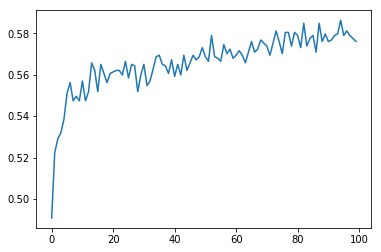

In [50]:
from matplotlib import pyplot as plt
plt.plot(history.history['val_acc'])

#### Evalutaion


In [51]:
loss, accuracy = model.evaluate(X_test, Y_test,verbose=0)  # Evaluate the model
print('Accuracy :%0.3f'%accuracy)

Accuracy :0.587


In [52]:
"""Test for model"""
model.metrics

['accuracy']

In [53]:
"""Test for model"""


'Test for model'

#### Confusion Matrix

In [0]:
def create_cm(Y_test, Y_pred):
    """
    Inputs:
        Y_test: numpy array with true labels
        Y_pred: numpy array with predicted labels
    Outputs:
        CM: numpy array (ndim=2) containing confusion matrix
    """
    # YOUR CODE HERE
    from sklearn.metrics import confusion_matrix
#     pred_Ytest = model.predict(Xtest)
    cm = confusion_matrix(Y_test.argmax(axis=1), Y_pred.argmax(axis=1))
#     print(cm )
    return cm

In [55]:
"""Test for confusion matrix"""
CM=create_cm(Y_test,model.predict(X_test))
print(CM)

[[ 78  19   1  41  30   9  34]
 [ 10  89  18  46  40   0   1]
 [  0  13 193  11   8   0   0]
 [ 20  31   4 121  19   0  11]
 [  9  26  10  27 141   0   2]
 [  1   0   0   2   0 199  14]
 [ 47   7   0  25  17  72  66]]


In [0]:
def precision(cm, cls):
    """
    Inputs:
        cm: numpy array of shape (Ny, Ny) containing confusion matrix
        cls: class for which precision has to be computed
    Outputs:
        prec: precision for class cls 
    """
    # YOUR CODE HERE
    sum=0
    for i in cm[:,cls]:
      sum+=i
    prec=cm[cls][cls]/sum
    return prec

In [57]:
precision(CM,2)

0.8539823008849557